In [1]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import pickle
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm,SymLogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers =['o','v','s','d','+','*']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize = (4*1.5,3*1.5)
pf = 1e-4

In [2]:
MODEL_NAME      = 'Ishigama'
DATA_DIR        = '/Users/jinsongliu/External/MUSE_UQ_DATA'
# DATA_DIR        = 'G:\My Drive\MUSE_UQ_DATA'

MODEL_DIR_DATA  = os.path.join(DATA_DIR,MODEL_NAME,r'Data')
MODEL_DIR_FIGURE= os.path.join(os.getcwd(), MODEL_NAME,r'Figures')
print(MODEL_DIR_FIGURE)

# class Ecdf2plot: 
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

/Users/jinsongliu/BoxSync/MUSELab/museuq/examples/Ishigama/Figures


In [3]:
def ishigami(x, p=None):
    """
    The ishigami function of ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on x3, as described by Sobol' & Levitan (1999). 

    The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1. Sobol' & Levitan (1999) use a = 7 and b = 0.05. 

    Input Distributions:
    The independent distributions of the input random variables are usually: xi ~ Uniform[-π, π], for all i = 1, 2, 3.

    References:
    Crestaux, T., Martinez, J.-M., Le Maitre, O., & Lafitte, O. (2007). Polynomial chaos expansion for uncertainties quantification and sensitivity analysis [PowerPoint slides]. Retrieved from SAMO 2007 website: http://samo2007.chem.elte.hu/lectures/Crestaux.pdf.

    I3shigami, T., & Homma, T. (1990, December). An importance quantification technique in uncertainty analysis for computer models. In Uncertainty Modeling and Analysis, 1990. Proceedings., First International Symposium on (pp. 398-403). IEEE.

    Marrel, A., Iooss, B., Laurent, B., & Roustant, O. (2009). Calculations of sobol indices for the gaussian process metamodel. Reliability Engineering & System Safety, 94(3), 742-751.

    Saltelli, A., Chan, K., & Scott, E. M. (Eds.). (2000). Sensitivity analysis (Vol. 134). New York: Wiley.

    Sobol', I. M., & Levitan, Y. L. (1999). On the use of variance reducing multipliers in Monte Carlo computations of a global sensitivity index. Computer Physics Communications, 117(1), 52-61.

    Arguments:
        x: array-like of shape(ndim, nsamples)
        p: parameters for ishigami
    Return:
        y: array-like (nsamples,)
    """
    x = np.array(x)
    p = p or [7, 0.1]
    assert x.shape[0] == int(3), 'Ishigami function expecting 3 random variables, {} given'.format(x.shape[0])

    if x.ndim == 1:
        y = np.sin(x[0]) + p[0] * np.sin(x[1])**2 + p[1]*x[2]**4 * np.sin(x[0])
    else:
        y = np.sin(x[0,:]) + p[0] * np.sin(x[1,:])**2 + p[1]*x[2,:]**4 * np.sin(x[0,:])
    return y


##  Ishigami function

\begin{equation}
\begin{aligned}
    f(x) &= \sin(x_1) + a \sin^2(x_2) + b x_3^4\sin(x_1) + \epsilon \\
    \epsilon &\sim p(\epsilon), \mathbb{E}[\epsilon] = 0, \mathrm{Var}[\epsilon] = \frac{1}{5}|f(x)|
\end{aligned}
\end{equation}

In [4]:
figsize = (4*1.5,3*1.5)
pf = 1e-4
noise_type = 'DATA_NOISE_FREE'
# x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
# metamodel_class, metamodel_basis= ['PCE', [8,9,10]]
ndoe2plot = list(np.arange(10,16))

In [15]:
dist_x = cp.J(cp.Uniform(-np.pi, np.pi),cp.Uniform(-np.pi, np.pi),cp.Uniform(-np.pi, np.pi))
x_samples = dist_x.sample(int(1e7))
print(x_samples.shape)
y_sampels = ishigami(x_samples)

(3, 10000000)


<IPython.core.display.Javascript object>


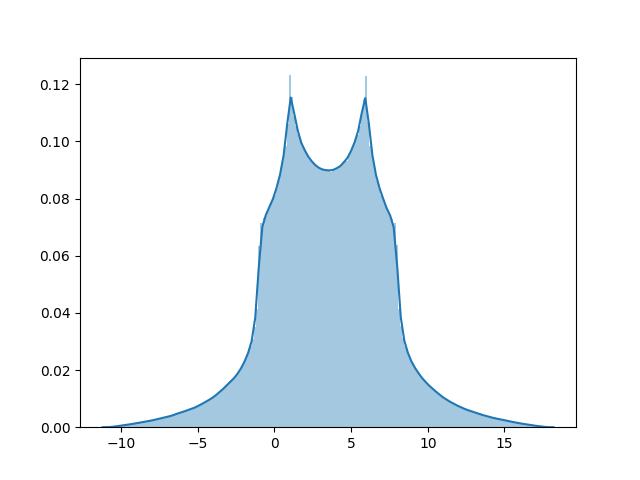

In [18]:
ax = sns.distplot(y_sampels,bins=200)